## 基于多目标GP的符号回归

多目标GP是指使用均方误差（MSE）和树的大小作为目标来进行遗传编程。这样，可以得到更为精简的模型。

In [1]:
import math
import operator
import random
from deap import base, creator, tools, gp, algorithms

# 定义评估函数，包含两个目标：均方误差和树的大小
def evalSymbReg(individual,pset):
    # 编译GP树为函数
    func = gp.compile(expr=individual, pset=pset)
    # 计算均方误差（Mean Square Error，MSE）
    mse = ((func(x) - x**2)**2 for x in range(-10, 10))
    # 计算GP树的大小
    size = len(individual)
    return math.fsum(mse), size

# 修改适应度函数，包含两个权重：MSE和树的大小。MSE是最小化，树的大小也是最小化
creator.create("FitnessMulti", base.Fitness, weights=(-1.0, -1.0))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMulti)

### 遗传算子
遗传算子基本不需要修改。由于是多目标优化问题，所以选择算子需要使用NSGA2（Non-dominated Sorting Genetic Algorithm II）。

In [2]:
import random

# 定义函数集合和终端集合
pset = gp.PrimitiveSet("MAIN", arity=1)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator.neg, 1)
pset.addEphemeralConstant("rand101", lambda: random.randint(-1, 1))
pset.renameArguments(ARG0='x')

# 定义遗传编程操作
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=2)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)
toolbox.register("evaluate", evalSymbReg, pset=pset)
toolbox.register("select", tools.selNSGA2)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

C:\Users\zhenl\anaconda3\Lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


### 算法模块
DEAP算法包提供了eaMuPlusLambda函数，可以比较方便地使用NSGA2的环境选择算子。然而，理想情况下，最好还是自行实现演化函数，这样才能完整地使用NSGA-II算法中的锦标赛选择算子。

In [3]:
import numpy
from deap import algorithms

# 修改统计指标以追踪两个目标
stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats_size = tools.Statistics(lambda ind: ind.fitness.values[1])
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", numpy.mean)
mstats.register("std", numpy.std)
mstats.register("min", numpy.min)
mstats.register("max", numpy.max)

# 使用默认算法
population = toolbox.population(n=50)
pop, log  = algorithms.eaMuPlusLambda(population=population,
                           toolbox=toolbox, mu=len(population),lambda_=len(population),
                                      cxpb=0.5, mutpb=0.2, ngen=50, stats=mstats, halloffame=None, verbose=True)

# 打印最佳个体
best_ind = tools.selBest(pop, 1)[0]
print('Best individual is:\n', best_ind)
print('\nWith fitness:', best_ind.fitness.values)


   	      	                    fitness                    	                      size                     
   	      	-----------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max  	min	nevals	std    	avg	gen	max	min	nevals	std    
0  	50    	39957.4	0  	47346	0  	50    	8480.79	4.3	0  	7  	2  	50    	1.61555
1  	29    	37488.6	1  	42026	0  	29    	9525.28	3.78	1  	7  	2  	29    	1.28515
2  	28    	34087.4	2  	40666	0  	28    	13739.2	3.1 	2  	6  	2  	28    	0.9    
3  	27    	27344.2	3  	40666	0  	27    	17824.1	3.02	3  	5  	2  	27    	0.96933
4  	36    	24180.5	4  	39346	0  	36    	18935.8	2.82	4  	5  	2  	36    	0.84119
5  	37    	17307.8	5  	39336	0  	37    	19525.9	2.56	5  	3  	2  	37    	0.496387
6  	37    	786.72 	6  	39336	0  	37    	5507.04	2.98	6  	3  	2  	37    	0.14    
7  	42    	786.72 	7  	39336	0  	42    	5507.04	2.98	7  	3  	2  	42    	0.14    
8  	35    	786.72 	8  	39336	0  	35    	5507.04	2.98	8  	3  	2  	

基于优化结果，我们还可以绘制Pareto前沿，以便于选择最终的模型。

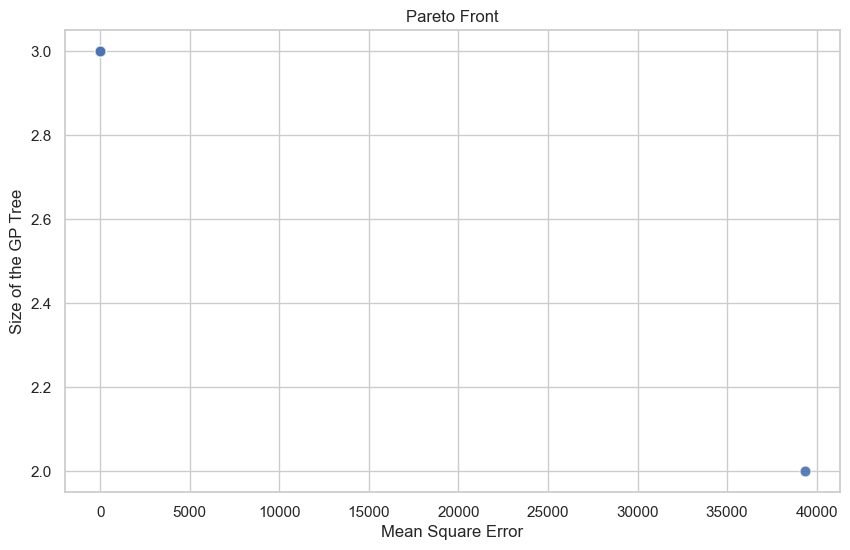

In [4]:
from matplotlib import pyplot as plt
import seaborn as sns

# 非支配排序
fronts = tools.sortNondominated(pop, len(pop), first_front_only=True)

# Pareto前沿
pareto_front = fronts[0]
fitnesses = [ind.fitness.values for ind in pareto_front]

# 分离均方误差和树的大小
mse = [fit[0] for fit in fitnesses]
sizes = [fit[1] for fit in fitnesses]

# 使用seaborn绘制散点图
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(x=mse, y=sizes, palette="viridis", s=60, edgecolor="w", alpha=0.7)
plt.xlabel('Mean Square Error')
plt.ylabel('Size of the GP Tree')
plt.title('Pareto Front')
plt.show()